## Import

In [35]:
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import stateinterpreter
from stateinterpreter.MD import Loader
from stateinterpreter.classifier import Classifier
from stateinterpreter.plot import plot_cvpath, plot_states, plot_combination_cvs_relevant_features
from importlib import reload
reload(stateinterpreter.classifier)
reload(stateinterpreter.MD)
reload(stateinterpreter.plot)

<module 'stateinterpreter.plot' from '../../stateinterpreter/plot.py'>

## Loader

In [22]:
chignolin_data_path = '../../../data/md_datasets/chignolin-unbiased/'
colvar_file = chignolin_data_path + 'COLVAR'
traj_dict = {
    'trajectory' : chignolin_data_path+'CLN025-0-protein-ALL.dcd',
    'topology' : chignolin_data_path+'CLN025-0-protein.pdb'
}

# Compute descriptors from Trajectory
data = Loader(colvar_file, kbt=2.5, stride=15)
data.colvar = data.colvar.rename(columns={'deep.node-4': 'tica1','deep.node-3': 'tica2','deep.node-2': 'tica3', 'deep.node-1': 'tica4','deep.node-0': 'tica5'})
data.load_trajectory(traj_dict)

## Identify states based on FES minima

In [31]:
# Collective variables used for classes identification
selected_cvs = ['tica1' , 'tica2', 'tica3']
bounds = [(-1.1,1.1)]*len(selected_cvs)
# Identify states
data.identify_states(selected_cvs,bounds,fes_cutoff=2*data.kbt)


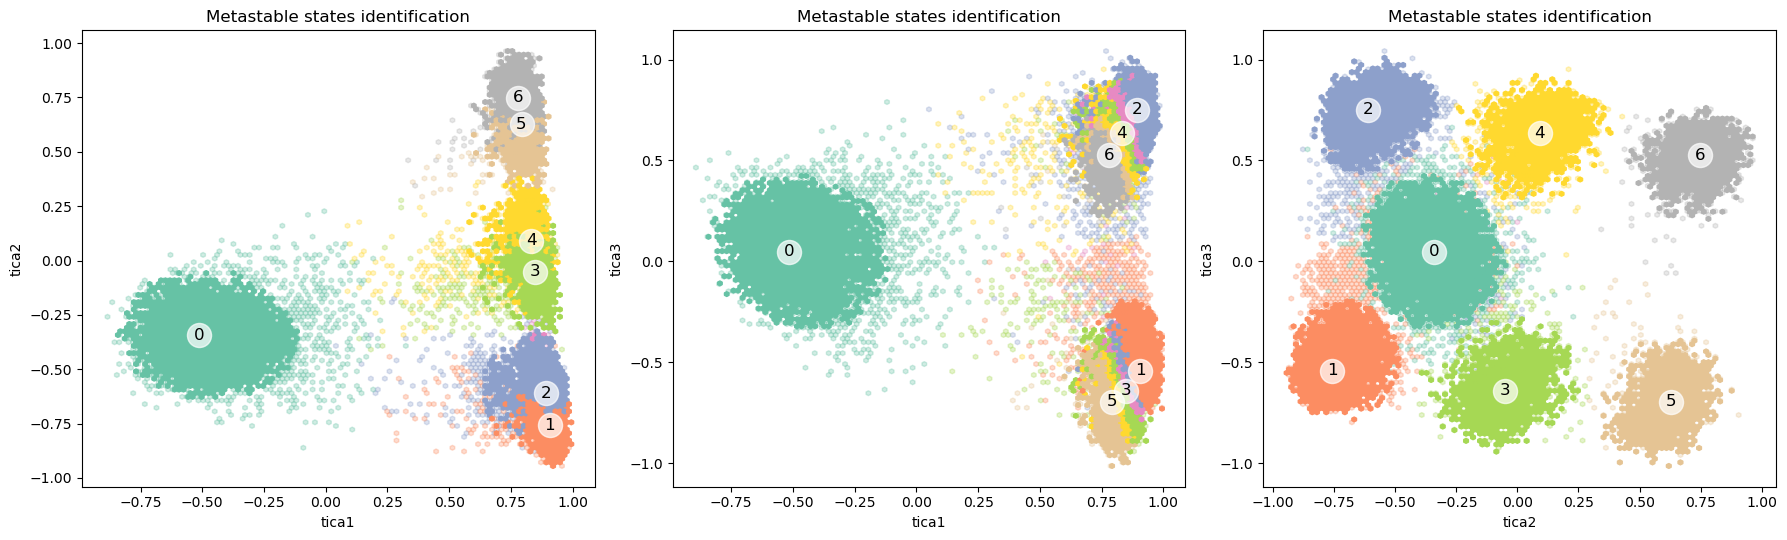

In [36]:
plot_states(data, fes_isolines=False, save_folder = states_folder)

## Stateinterpreter

In [ ]:
from stateinterpreter.classifier import MD_Data, CV_path

states_folder = 'results/chignolin-unbiased/tica-1d/'

# Load input from file
df = pd.read_csv(states_folder+'dataframe.txt', sep=' ')

# or directly from dataframe
model = MD_Data(df)

# input features
select_feat = 'HB_CONTACT|sin_|cos_'
sample = model.sample(1000, regex_filter = select_feat)

# Define results folder (save plots and results) 
results_folder = states_folder + 'hbonds-angles/'
!mkdir -p {results_folder}

### Linear Kernel

In [ ]:
C_range = np.geomspace(1, 100, 25)
kwargs = {'LASSO':True, 'max_iter': 10000}
dset = sample.train_test_dataset()
n_examples = dset[0].shape[0]
C_range_in = C_range/n_examples
cvpath = CV_path(dset, sample.features, quadratic_kernel=False)

result = cvpath.compute(C_range_in,multi_class='ovr', **kwargs)

In [ ]:
from stateinterpreter.plot import plot_cvpath

C = np.power(10,1)

# PLOT
base_prefix = 'linear'
plot_cvpath(cvpath,C)

if results_folder is not None:
    plt.savefig(results_folder+base_prefix+'-cvpath.png', facecolor='w', transparent=False, bbox_inches='tight')
plt.show()

In [ ]:
relevant_feat = cvpath.relevant_features(C)
unique_features = cvpath.unique_features(C)

print('\n-- RELEVANT FEATURES --')
cvpath.print_relevant_features(C)

# save to file
if results_folder is not None:
    with open(results_folder+base_prefix+'-features.txt', 'w') as f:
        cvpath.print_relevant_features(C,file=f)

In [ ]:
from stateinterpreter.plot import plot_combination_cvs_relevant_features

plot_combination_cvs_relevant_features(df,selected_cvs,relevant_feat, 
                                       save_folder=results_folder,file_prefix=base_prefix)

### Quadratic kernel

In [ ]:
# Create quadratic Kernel based on features selected with C value above
prunedcv = cvpath.get_pruned_CVpath(C)
prunedcv.compute(C_range_in, **kwargs);

In [ ]:
C = np.power(10,1)

# PLOT
base_prefix = 'pruned'
plot_cvpath(prunedcv,C)

if results_folder is not None:
    plt.savefig(results_folder+base_prefix+'-cvpath.png', facecolor='w', transparent=False, bbox_inches='tight')
plt.show()

In [ ]:
relevant_feat = prunedcv.relevant_features(C)
unique_features = prunedcv.unique_features(C)

print('\n-- RELEVANT FEATURES --')
prunedcv.print_relevant_features(C)

# save to file
if results_folder is not None:
    with open(results_folder+base_prefix+'-features.txt', 'w') as f:
        prunedcv.print_relevant_features(C,file=f)

# add quadratic features to dataframe
for feat in unique_features:
    if "||" in feat:
        if feat not in df.columns: 
            i, j = feat.split(' || ')
            feat_ij = df[i].values * df[j].values
            df[feat] = feat_ij

In [ ]:
plot_combination_cvs_relevant_features(df,selected_cvs,relevant_feat, 
                                       save_folder=results_folder,file_prefix=base_prefix)

## Visualize features

In [ ]:
from stateinterpreter.plot import visualize_features

view = visualize_features(data,relevant_feat,state=1)   
view

In [ ]:
view.download_image(filename='results/chignolin-unbiased/chignolin-hbonds.png')